**Create quantizised version of GPT-2 and save the memory =)**

Egor Shvetsov, Viktoriia Chekalina

In [5]:
! pip install transformers

In [6]:
device = 'cuda:0'

## Class Quantizator

In [7]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

![](https://drive.google.com/uc?export=view&id=1qG2l66t1tZNk-V-CQs80e-DiyevAF2ea)

In [8]:
class Quantizer(nn.Module):
    def __init__(self, bit):

        super(Quantizer, self).__init__()
        self.bit = bit
        self.thd_neg = -(2 ** (bit - 1))
        self.thd_pos = 2 ** (bit - 1) - 1
        #print ("bit, pos, neg", bit, self.thd_neg, self.thd_pos)
        self.s = nn.Parameter(torch.ones(1))

    def init_from(self, x):
        #print ("x.max(), x.min()", x.max(), x.min())
        s = (x.max() - x.min()) / (self.thd_pos - self.thd_neg )
        #print ("s", s)
        self.s = nn.Parameter(s)

    def skip_grad_scale(self,x, scale):
        y = x
        y_grad = x * scale
        return (y - y_grad).detach() + y_grad

    def round_pass(self, x): # round ans clip are not differentiable
        y = x.round()
        y_grad = x
        return (y - y_grad).detach() + y_grad

    def forward(self, x):
        if self.bit >= 32:
            return x

        s_grad_scale = 1.0 / ((self.thd_pos * x.numel()) ** 0.5)

        #print ("s_grad_scale", s_grad_scale)
        device = x.device

        s_scale = self.skip_grad_scale(self.s, s_grad_scale).to(device)

        #print ("s_scale", s_scale)

        x = x / (s_scale) # go to new space
        x = torch.clamp(x, self.thd_neg, self.thd_pos) # clip
        x = self.round_pass(x) #go back
        x = x * (s_scale)
        return x

In [9]:
vector =(np.arange(-10, 10, 1))**2

In [10]:
vector

array([100,  81,  64,  49,  36,  25,  16,   9,   4,   1,   0,   1,   4,
         9,  16,  25,  36,  49,  64,  81])

In [11]:
quantizer = Quantizer(2)
vector = torch.tensor(vector)
quantizer.init_from(vector)
quantizer(vector).detach().numpy()

array([33.333332, 33.333332, 33.333332, 33.333332, 33.333332, 33.333332,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      , 33.333332, 33.333332, 33.333332,
       33.333332, 33.333332], dtype=float32)

In [12]:
quantizer.s

Parameter containing:
tensor(33.3333, requires_grad=True)

In [13]:
quantizer = Quantizer(16)
vector = torch.tensor(vector)
quantizer.init_from(vector)
quantizer(vector).detach().numpy()

<ipython-input-13-f6c3db215e95>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vector = torch.tensor(vector)


array([49.999237  , 49.999237  , 49.999237  , 48.99977   , 36.00061   ,
       25.000381  , 16.00061   ,  8.999771  ,  3.9993896 ,  0.99946594,
        0.        ,  0.99946594,  3.9993896 ,  8.999771  , 16.00061   ,
       25.000381  , 36.00061   , 48.99977   , 49.999237  , 49.999237  ],
      dtype=float32)

<Figure size 1000x700 with 0 Axes>

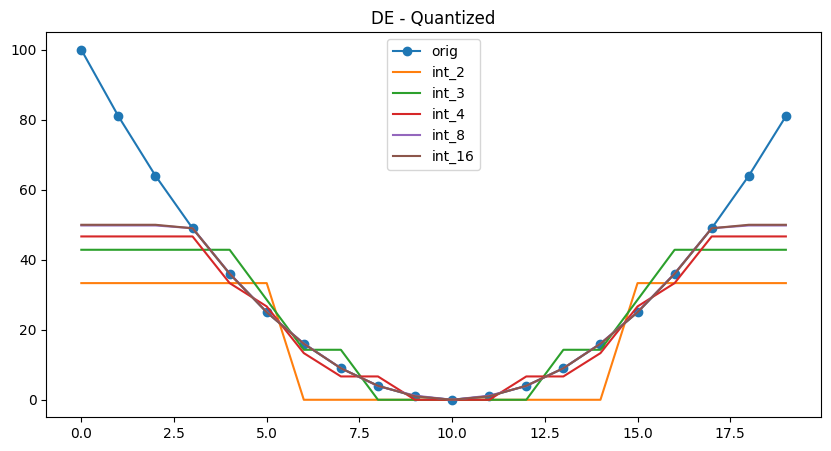

In [14]:
vector =(np.arange(-10, 10, 1))**2

vector = torch.tensor(vector)

plt.figure(figsize=(10,7))

f = plt.figure(figsize = (10, 5))

plt.plot(range(len(vector)), vector,label='orig', marker='o')
for bit in [2,3,4, 8, 16]:
    quantizer = Quantizer(bit)
    quantizer.init_from(vector) # define step
    dequantized = quantizer(vector) #

    dequantized = dequantized.detach().numpy()

    plt.plot(range(len(vector)),dequantized,label=f'int_{bit}')

plt.title('DE - Quantized');
plt.legend();

In [15]:
def plot_weight_distribution(model, bitwidth=32):

    fig, axes = plt.subplots(1,len([(p,n) for (p,n) in model.named_parameters()])-1, figsize=(15, 5))

    quantizer = Quantizer(bitwidth)
    qmin, qmax = quantizer.thd_neg,  quantizer.thd_pos,
    for i, (name, param) in enumerate(model.named_parameters()):
        if param.dim() > 1:
            quantizer.init_from(param)
            dequantized = quantizer(param)
            dequantized = dequantized.detach().cpu().numpy()

            axes[i].hist(dequantized.flatten(),  density=True, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)

            axes[i].set_xlabel(name)
            axes[i].set_ylabel('density')

    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

In [16]:
class QALinear(nn.Module):
    def __init__(self, fc_w, fc_b, bit):
        super(QALinear, self).__init__()
        self.bit = bit
        self.in_features, self.out_features = fc_w.shape
        self.fc = nn.Linear(in_features = self.in_features,
                      out_features = self.out_features,
                      bias = True)
        self.fc.weight = torch.nn.Parameter(torch.t(fc_w))
        self.fc.bias = fc_b
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weigh = Quantizer(bit)
        self.quantizer_weigh.init_from(self.fc.weight)

        self.quantizer_bias = Quantizer(bit)

    def forward(self, input_x):
        quantized_weight = self.quantizer_weigh(self.fc.weight)
        quantized_bias = self.quantizer_weigh(self.fc.bias)
        quantized_act = self.quantizer_act(input_x)
        out = nn.functional.linear(quantized_act, quantized_weight, bias=quantized_bias) #torch.nn.functional.linear(input, weight, bias)
        return out

# Transformer-based model quantization

### GPT-2 quantization pipeline

1) Extract fully-connected (transformers.conv1D()) from pretrained GPT-2

2) Create quantized QALinear object over it

3) Replace initial fully-connected layer with quantized layer

4) Fine-tune model to recover performance degradation


## Let's go through all of the stages in the pipeline

In [17]:
import numpy as np

In [19]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config()

print(f'memory before start: {cuda_memory()}')
parameters = cuda_memory()
# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)

#print(f'memory after layer initializing: {cuda_memory()}')
#print(f'size of full model: {cuda_memory() - parameters}')

memory before start: 0.0


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

We will validate a pre-trained language GPT-2 model on a validation part **Wikitext-103** dataset.

To create a validation dataset we should:
    
- download archieved dataset
- extract it
- wrap tran and test parts in TextDataset and further Dataloader class

In [20]:
!pwd
!curl https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip -o wikitext-103-v1.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181M  100  181M    0     0  37.1M      0  0:00:04  0:00:04 --:--:-- 41.4M


In [21]:
rm -r ./wikitext-103/

rm: cannot remove './wikitext-103/': No such file or directory


In [22]:

!unzip wikitext-103-v1.zip


Archive:  wikitext-103-v1.zip
   creating: wikitext-103/
  inflating: wikitext-103/wiki.test.tokens  
  inflating: wikitext-103/wiki.valid.tokens  
  inflating: wikitext-103/wiki.train.tokens  


Create a validation dataset and measure perplexity of regular GPT-2

In [23]:
from torch.utils.data import DataLoader, RandomSampler
from transformers import GPT2Tokenizer
from transformers import TextDataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")


dataset_valid = TextDataset(tokenizer=tokenizer,
                                file_path="./wikitext-103/wiki.valid.tokens", #file_path="/content/wikitext-103/wiki.valid.tokens",
                                block_size=512)

dataset_test = TextDataset(tokenizer=tokenizer,
                                file_path="./wikitext-103/wiki.test.tokens", block_size=512)

len(dataset_valid), len(dataset_test)

eval_dataloader = DataLoader(dataset_valid, batch_size=10)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Validate model and calculate a perplexity:

In [24]:
from tqdm import tqdm
model.eval()
import torch

def evaluate(model):
    losses = []
    eval_loss = 0.0
    perplexity = 0.0
    nb_eval_steps = 0
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
            perplexity += torch.exp(torch.tensor(eval_loss))
            losses.append(eval_loss)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    perplexity = torch.exp(torch.tensor(eval_loss))
    perplexity = perplexity
    return perplexity

In [25]:
perplexity = evaluate(model)
perplexity

Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s]


tensor(35.1143)

In [26]:
model.transformer.h[1].mlp.c_fc.weight.shape

torch.Size([768, 3072])

Let's generate text to ensure that model is good.

In [27]:
seq_len = 512

In [31]:
i = 0
for batch_idx, sample in tqdm(enumerate(eval_dataloader)):
    input_ids, label_ids = sample[0][:seq_len - 1], sample[0][1:seq_len]
    input_ids = input_ids.to(device=device)
    label_ids = label_ids.to(device=device)
    outputs = model(input_ids)
    print ("\n")
    print("input_ids[0][-20:]", tokenizer.decode(input_ids[-10:]))
    print ("\n")
    print("label_ids[0][-21:]", tokenizer.decode(input_ids[-9:]))
    print ("\n")
    print("output", tokenizer.decode(outputs.logits.argmax(dim=-1)[-10:]))
    #print("GENERATED", tokenizer.decode(outputs.logits.argmax(dim=-1)[0][-1:]))
    print("\n\n\n")
    i += 1
    if i > 10: break
    print ("\n\n")

2it [00:00,  7.92it/s]



input_ids[0][-20:]  lobster, Homarus americanus. The two species


label_ids[0][-21:] , Homarus americanus. The two species


output , Harus gamanus. It American species are









input_ids[0][-20:]  National Forest. The east end of M @-


label_ids[0][-21:]  Forest. The east end of M @-


output  Forest. The highwaybound of the @-@









4it [00:00,  9.76it/s]



input_ids[0][-20:]  as a liaison between the organizations. Plans were underway


label_ids[0][-21:]  a liaison between the organizations. Plans were underway


output  a liaison between the Meridian and  for made to









input_ids[0][-20:]  @-@ seat auditorium for live performances,


label_ids[0][-21:] -@ seat auditorium for live performances,


output ,@ and,ium, the performances, is









input_ids[0][-20:]  @,@ 
 Fred and Al Key,


label_ids[0][-21:] ,@ 
 Fred and Al Key,


output ,@ 

rick Mary <es the









8it [00:00, 12.16it/s]



input_ids[0][-20:] le was the villain. 
 
 =


label_ids[0][-21:]  was the villain. 
 
 =


output  is a main. 
 "
 = =









input_ids[0][-20:] @ northwesterly track in response to a


label_ids[0][-21:]  northwesterly track in response to a


output  orientationwardesterly direction, the to the strong









input_ids[0][-20:]  is shown standing in a cage opposite to a number


label_ids[0][-21:]  shown standing in a cage opposite to a number


output  singing dancing in front white with the the man of









input_ids[0][-20:] 

10it [00:00, 10.97it/s]

-@ lap sprint, Richmond competed in a three


label_ids[0][-21:] @ lap sprint, Richmond competed in a three


output @ race,, Richmond took in the race @









input_ids[0][-20:]  well @-@ being of ranchers. In


label_ids[0][-21:]  @-@ being of ranchers. In


output --@ needs of localhers.  addition









input_ids[0][-20:]  for their first road win in Illinois since 1995.


label_ids[0][-21:]  their first road win in Illinois since 1995.


output  the first Big win of four'beating. On






In [32]:
for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc
    fp_w = model.transformer.h[i].mlp.c_proj
    model.transformer.h[i].mlp.c_fc = QALinear(fc_w.weight, fc_w.bias, 16)
    model.transformer.h[i].mlp.c_proj = QALinear(fp_w.weight, fp_w.bias, 16)

In [33]:
perplexity = evaluate(model)
perplexity

Evaluating: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s]


tensor(231.6536)

## Fine-tune the model

In [ ]:
dataset_train = TextDataset(tokenizer=tokenizer,
                                file_path="./wikitext-103/wiki.train.tokens", block_size=512)


/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=5)

In [ ]:
from transformers import get_cosine_schedule_with_warmup

In [ ]:
from tqdm import tqdm

epochs = 10
gradient_accumulation_steps = 24
num_train_batches = len(train_dataloader)
cross_entropy = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.eos_token_id)
training_steps = num_train_batches // gradient_accumulation_steps * epochs
optimizer = torch.optim.Adam(model.parameters(), lr=1.25e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=800, num_training_steps=training_steps)


for epoch in range(2):

    train_loss = 0
    epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
    for train_batch_idx, item in enumerate(epoch_iterator):
        optimizer.zero_grad() # in case there are unused accumulated gradients

        model.train()
        src, tgt = (item, item)
        src = src.to(device=device)
        tgt = tgt.to(device=device)


        output = model(input_ids=src, labels=tgt)
        loss = output.loss
        train_loss += loss.item() # before gradient accumulation step
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward() # accumulate gradients

        if train_batch_idx % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            optimizer.zero_grad()

        if train_batch_idx % 500 == 0:
            print ("loss", loss)
            perplexity = evaluate(model)
            print ("perplexity", perplexity)


In [ ]:
perplexity = evaluate(model)
perplexity

Evaluating: 100% 49/49 [00:04<00:00,  9.81it/s]


tensor(38.1063)

In [ ]:
i = 0
for batch_idx, sample in tqdm(enumerate(eval_dataloader)):
    input_ids, label_ids = sample[0][:seq_len - 1], sample[0][1:seq_len]
    input_ids = input_ids.to(device=device)
    label_ids = label_ids.to(device=device)
    outputs = model(input_ids)
    print ("\n")
    print("input_ids[0][-20:]", tokenizer.decode(input_ids[-10:]))
    print ("\n")
    print("label_ids[0][-21:]", tokenizer.decode(input_ids[-9:]))
    print ("\n")
    print("output", tokenizer.decode(outputs.logits.argmax(dim=-1)[-10:]))
    #print("GENERATED", tokenizer.decode(outputs.logits.argmax(dim=-1)[0][-1:]))
    print("\n\n\n")
    i += 1
    if i > 10: break
    print ("\n\n")